# Face Mask Detection

Since the beginning of 2020, Covid-19 has brought the world to a halt. Starting in Wuhan in December 2019, the coronavirus spread worldwide rapidly. At the time of writing, 281 million people had gotten Covid-19, and 5.4 million people died. In the fight against the novel virus, many preventative measures, including social distancing, masking, and lockdowns, were set in place. Wearing a face mask remains one of the most effective ways to prevent the spread of Covid-19 in public areas. In addition, face mask detection is an excellent application for facial attribute classification problems. 

Using the [Face Mask Detection dataset](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection) from Kaggle, the project aims to explore Deep Learning techniques for detecting face masks.

## 0. Define constants

In [1]:
input_path = './'
preprocessed_path = './preprocessed'
image_size = 224

## 1. Data Exploration

### 1.1. Image Annotation

We annotate bounding boxes with color graded boxes to highlight the corresponding class of each bounding box. 

In [2]:
colors = {
    'with_mask': 'green',
    'without_mask': 'red',
    'mask_weared_incorrect': 'orange',
}

We define a method that takes the image to be annotated and all the bounding boxes within it. For each bounding box, we draw a colored rectangle to show whether a person is wearing mask correctly.

A few images are annotated as part of our data exploration.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def annotate_image(path: str, rects: list) -> None:
    im = Image.open(path)

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(im)
    
    for (xmin, ymin, xmax, ymax, color) in rects:
        # Create a Rectangle patch
        patch = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor=color, facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(patch)

    plt.show()

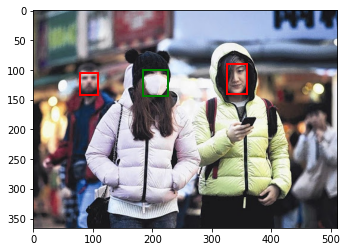

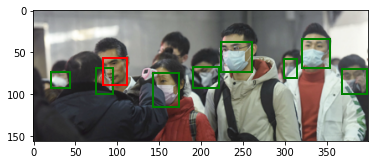

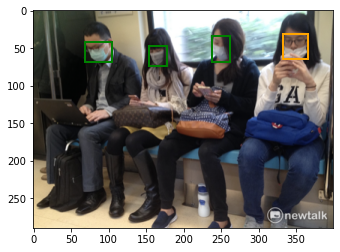

In [4]:
import xmltodict

image_ids = list(range(0, 3))

for image_id in image_ids:
    with open(f'{input_path}/annotations/maksssksksss{image_id}.xml') as f:
        annotation = xmltodict.parse(f.read())
        annotation = annotation['annotation']
        annotation_object = [annotation['object']]
        if annotation_object:
            objects = annotation_object[0]
            if type(objects) is not list:
                objects = [objects]
            rects = [(int(obj['bndbox']['xmin']), int(obj['bndbox']['ymin']), int(obj['bndbox']['xmax']), int(obj['bndbox']['ymax']), colors[obj['name']]) for obj in objects]
            annotate_image(f'{input_path}/images/maksssksksss{image_id}.png', rects)

### 1.2. Data Analysis

There are 3 classes in the dataset:
- With mask;
- Without mask;
- Mask worn incorrectly.

We iterate through all XML annotation files and count the number of faces for each class.

In [5]:
import os
import xmltodict

# Define initial counts for each class
count = {
    'with_mask': 0,
    'without_mask': 0,
    'mask_weared_incorrect': 0,
}

# Iterate through annotation files and count the number of each classes
for dirname, _, filenames in os.walk(f'{input_path}/annotations'):
    for filename in filenames:
        with open(os.path.join(dirname, filename)) as f:
            annotation = xmltodict.parse(f.read())
            annotation = annotation['annotation']
            annotation_object = [annotation['object']]
            if annotation_object:
                objects = annotation_object[0]
                if type(objects) is not list:
                    objects = [objects]
                for obj in objects:
                    count[obj['name']] += 1

#### 1.2.1. Data Distribution

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

A pie chart is used to show the data distribution amongst the classes. As it can be observed, the data is skewed heavily towards *with_mask* class (~80%).

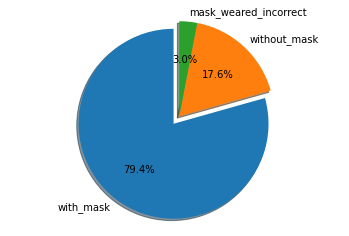

In [7]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(count.keys())
sizes = list(count.values())
explode = (0.1, 0, 0)  # only "explode" the 1st slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

A bar chart is also used to present a different view into the data distribution.

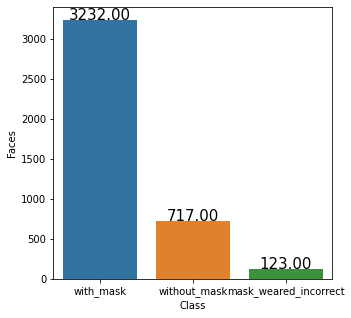

In [8]:
# Creating our own dataframe
data = {"Class": list(count.keys()),
        "Faces": list(count.values())}
 
# Now convert this dictionary type data into a pandas dataframe
# specifying what are the column names
df = pd.DataFrame(data, columns=['Class', 'Faces'])
 
# Defining the plot size
plt.figure(figsize=(5, 5))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="Class", y="Faces", data=df)
 
# Iterrating over the bars one-by-one
for bar in plots.patches:
   
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 5),
                   textcoords='offset points')
 
# Finally showing the plot
plt.show()

## 2. Data Preprocessing

The `DataPreprocess` class provides a preprocess method that takes a path of an image and its annotation objects. 

For each annotation object, the included bounding box/face is cropped out from the original image, resized to `224*224` pixels and saved to a new image. The included label is appended to the instance variable `labels`, which is a list of labels.

Based on our observation from data exploration, the `mask_weared_incorrect` class is skipped due to very low data distribution. Since only 3% of the data belongs to this class, not only the prediction for that class will be poor but also it will affect predictions for other classes.

In [9]:
import csv
from pathlib import Path
from PIL import Image
from torchvision import transforms

In [10]:
label_map = {
    'with_mask': 1, # wearing mask
    'without_mask': 0, # not wearing mask
    'mask_weared_incorrect': -1, # skip this class
}

class DataPreprocess:
    
    def __init__(self, processed_dir, image_size):
        self.count = 0
        self.labels = []
        self.processed_dir = processed_dir
        self.transform = transforms.Compose([transforms.Resize((image_size, image_size))])        
        Path(self.processed_dir).mkdir(parents=True, exist_ok=True)

    def _preprocess_image(self, image, processed_path: str, bndbox: dict) -> None:
        xmin, ymin, xmax, ymax = int(bndbox['xmin']), int(bndbox['ymin']), int(bndbox['xmax']), int(bndbox['ymax'])
        # Crop image
        crop = image.crop((xmin, ymin, xmax, ymax))
        crop = self.transform(crop)
        # Save cropped image
        crop.save(processed_path)

    def preprocess(self, image_path: str, objects: list) -> None:
        image = Image.open(image_path)

        for obj in objects:
            # Save label
            label = label_map[obj['name']]
            # Skip not wearing mask
            if label == -1: 
                continue
            self.labels.append(label)
            # Process image
            bndbox = obj['bndbox']
            processed_path = f'{self.processed_dir}/{self.count}.png'
            self._preprocess_image(image, processed_path, bndbox)
            # Increase index for next object
            self.count += 1

In [11]:
image_ids = list(range(0, 853))

data_preprocess = DataPreprocess(f'{preprocessed_path}/images', image_size)

# Iterate through XML annotation files
for image_id in image_ids:
    with open(f'{input_path}/annotations/maksssksksss{image_id}.xml') as f:
        annotation = xmltodict.parse(f.read())
        annotation = annotation['annotation']
        annotation_object = [annotation['object']]
        if annotation_object:
            objects = annotation_object[0]
            if type(objects) is not list:
                objects = [objects]
            data_preprocess.preprocess(f'{input_path}/images/maksssksksss{image_id}.png', objects)

print(data_preprocess.count)

3949


The `labels` instance variable from `DataPreprocess` class is saved to a csv file to reduce the need to preprocess data repeatedly.

In [12]:
import csv

with open(f'{preprocessed_path}/annotation.csv', 'w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',')
    labels = [[label] for label in data_preprocess.labels]
    csv_writer.writerows(labels)

## 3. Load Preprocessed Data

The image data is read into a numpy array with a shape of `(224, 224, 4)`. After dropping the alpha channel and reordering, the array has a shape of `(3, 224, 224)`, which presents `224*224` pixels and 3 color channels. 

The pixel value is normalized to `(0, 1)` by dividing by 255.

In [13]:
import numpy as np
import csv
from PIL import Image
from torch.autograd import Variable

In [14]:
x = []

for index in range(3949):
    # defining the image path
    image_path = f'{preprocessed_path}/images/{index}.png' 
    # reading the image
    img = Image.open(image_path)
    img = np.array(img)
    # dropping alpha channel
    img = img[:, :, :3]
    # change image channel ordering
    img = np.moveaxis(img, -1, 0)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # normalizing the pixel values
    img /= 255.0
    # appending the image into the list
    x.append(img)

In [15]:
# converting the list to numpy array
X = np.array(x)
X.shape

(3949, 3, 224, 224)

Labels are read from preprocessed annotation CSV file and saved to a numpy array

In [16]:
# reading labels from annotation csv file
labels = []
with open(f'{preprocessed_path}/annotation.csv', 'r', newline='') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        labels.append(int(row[0]))

In [17]:
# converting labels to numpy array
y = np.array(labels)
y.shape

(3949,)

### 3.1. Training and Testing Data Split

The data is split to training and testing data with `70:30` ratio (70% training data and 30% testing data).

In [18]:
from sklearn.model_selection import train_test_split

# splitting training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2764, 3, 224, 224), (2764,), (1185, 3, 224, 224), (1185,))

In [19]:
import torch

X_train, X_test, y_train, y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test)

## 4. Build Model

### 4.1. Define CNN model

We define a CNN with 3 Convolution Layers and 1 Fully Connected Layer. The Convolution Layers increase input channels from 3 to 4 to 8 to 16. Each Convolution Layer is paired with a Batch Normalization Layer, a ReLU activation function, and a Pooling Layer. The Batch Normalization Layers are used to accelerate the speed of the model training by eliminating internal covariate shift problem. The Pooling Layers are used to reduce the dimensions of input features, which reduces the number of trainable parameters. These Pooling Layers decrease the dimension of the input features from `224*224` to `112*112` to `56*56` to `28*28`.

The Fully Connected layer is a linear that takes `16*28*28=12544` input features and output 2 features for binary classification.

The forward method passes output from Convolution layers to the Fully Connected layer.

In [20]:
import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

In [21]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Layer 1: (*, 3, 224, 224) (Conv2d)-> (*, 4, 224, 224) (Pool)-> (*, 4, 112, 112)
            nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 2: (*, 4, 112, 112) (Conv2d)-> (*, 8, 112, 112) (Pool)-> (*, 8, 56, 56)
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 3: (*, 8, 56, 56) (Conv2d)-> (*, 16, 56, 56) (Pool)-> (*, 16, 28, 28)
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layer
        self.linear_layers = nn.Sequential(
            nn.Linear(16 * 28 * 28, 2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

We use the popular Adam optimizer with a learning rate of `0.07` and Cross Entry for loss function. 

One thing to highlight is the weights for our classes. Since our data is skewed towards with_mask (1) class (79.4%), training the model with equal weights results in favor of the dominating class. To avoid this, we give a weight of `60/100` to without_mask (0) class and `40/100` to with_mask (1) class.

In [22]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = nn.CrossEntropyLoss(weight=torch.tensor([60.0, 40.0]))
# checking if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


### 4.2. Training

We define a training method that performs back propagation and run the method with 30 iterations.

In [23]:
losses = []

def train(epochs):
    batch_size = 128
    
    for epoch in range(epochs):
        inputs, labels = Variable(X_train), Variable(y_train)

        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        # prediction for training and validation set
        outputs = model(inputs)

        # computing the training and validation loss
        loss = criterion(outputs, labels)

        # computing the updated weights of all the model parameters
        loss.backward()
        optimizer.step()

        # printing the validation loss
        print('Epoch : ', epoch+1, '\t', 'loss :', loss)
        
        losses.append(loss)

In [24]:
train(30)

Epoch :  1 	 loss : tensor(1.0368, grad_fn=<NllLossBackward0>)
Epoch :  2 	 loss : tensor(137.5457, grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(80.7127, grad_fn=<NllLossBackward0>)
Epoch :  4 	 loss : tensor(100.2310, grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(22.2846, grad_fn=<NllLossBackward0>)
Epoch :  6 	 loss : tensor(5.6183, grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(7.7409, grad_fn=<NllLossBackward0>)
Epoch :  8 	 loss : tensor(5.5863, grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(2.7331, grad_fn=<NllLossBackward0>)
Epoch :  10 	 loss : tensor(1.5610, grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(1.5031, grad_fn=<NllLossBackward0>)
Epoch :  12 	 loss : tensor(1.6836, grad_fn=<NllLossBackward0>)
Epoch :  13 	 loss : tensor(1.7230, grad_fn=<NllLossBackward0>)
Epoch :  14 	 loss : tensor(1.6098, grad_fn=<NllLossBackward0>)
Epoch :  15 	 loss : tensor(1.4746, grad_fn=<NllLossBackward0>)
Epoch :  16 	 loss : tensor(1.3880, grad_fn

In [25]:
import matplotlib.pyplot as plt

def plot_loss(losses: list):
    plt.plot(list(range(len(losses))), losses)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.show()

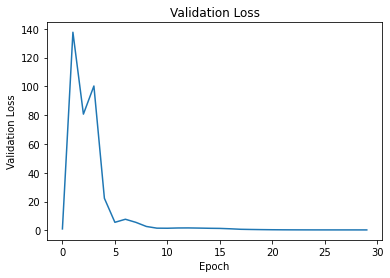

In [26]:
plot_loss([x.item() for x in losses])

### 4.3. Evaluation

The model is set to evaluation mode and makes prediction for test inputs. A confusion matrix is built to calculate the metrics including precision, recall, specificity, negative_rate and f1-score.

In [27]:
model.eval()
test_inputs, test_labels = Variable(X_test), Variable(y_test)

In [28]:
# call prediction on test inputs
prediction = model(test_inputs)

In [29]:
# extract results of the prediction by choosing the index/class with maximum score
res = torch.max(prediction.data, dim=1)[1]

# initialize counters for confusion matrix
with_mask_true = 0
with_mask_false = 0
without_mask_true = 0
without_mask_false = 0

# iterate through results and count numbers for confusion matrix
for i, pred in enumerate(res):
    test_label = test_labels.data[i]
    if test_label == 1:
        if test_label == pred: with_mask_true += 1
        else: with_mask_false += 1
    else:
        if test_label == pred: without_mask_true += 1
        else: without_mask_false += 1
        
print(f"with_mask_true: {with_mask_true}\nwith_mask_false: {with_mask_false}\nwithout_mask_true: {without_mask_true}\nwithout_mask_false: {without_mask_false}")

with_mask_true: 883
with_mask_false: 77
without_mask_true: 150
without_mask_false: 75


In [30]:
def calculate_metrics(tp: int, fp: int, tn: int, fn: int):
    precision, recall, specificity, negative_rate = tp / (tp+fp), tp / (tp+fn), tn / (tn+fp), tn / (fn+tn)
    f1 = 2 * (precision*recall) / (precision + recall)
    print("Precision: {:0.2f}%\nRecall: {:0.2f}%\nSpecificity: {:0.2f}%\nNegative Rate: {:0.2f}%\nF1: {:0.2f}%".format(precision*100, recall*100, specificity*100, negative_rate*100, f1*100))

In [31]:
calculate_metrics(with_mask_true, with_mask_false, without_mask_true, without_mask_false)

Precision: 91.98%
Recall: 92.17%
Specificity: 66.08%
Negative Rate: 66.67%
F1: 92.08%


## 5. Transfer Learning

We explore using Transfer Learning for face mask detection with [MobileNetV3](https://www.google.com/url?q=https://arxiv.org/abs/1905.02244&sa=D&source=docs&ust=1648229219308805&usg=AOvVaw1V4-8HV1Z2Fgb1yl0YsGV6) 

### 5.1. Update model

We replace the model's last fully connected layer with our own to support binary classification since the model was originally trained to classify 1000 classes. Since `MobileNetV3` has about *3 million* trainable parameters, we freeze the rest of the model weights to avoid expensive re-training. 

In [32]:
from torchvision import models

In [33]:
tl_model = models.mobilenet_v3_small(pretrained=True)

In [34]:
# show the last layer
tl_model.classifier[-1]

Linear(in_features=1024, out_features=1000, bias=True)

In [35]:
# freeze model weights
for param in tl_model.parameters():
    param.requires_grad = False
# redefine last layer to support binary classification
tl_model.classifier[-1] = nn.Sequential(nn.Linear(1024, 2))
for param in tl_model.classifier[-1].parameters():
    param.requires_grad = True

### 5.2. Training

In [36]:
import torch
from torch import nn
from torch.optim import Adam

In [37]:
# defining the optimizer
tl_optimizer = Adam(tl_model.parameters(), lr=0.07)
# defining the loss function
tl_criterion = nn.CrossEntropyLoss()

In [38]:
def train(epochs):
    batch_size = 128
    
    for epoch in range(epochs):
        inputs, labels = Variable(X_train), Variable(y_train)

        # clearing the Gradients of the model parameters
        tl_optimizer.zero_grad()

        # prediction for training and validation set
        outputs = tl_model(inputs)

        # computing the training and validation loss
        loss = tl_criterion(outputs, labels)

        # computing the updated weights of all the model parameters
        loss.backward()
        tl_optimizer.step()

        # printing the validation loss
        print('Epoch : ', epoch+1, '\t', 'loss :', loss)

In [39]:
train(30)

Epoch :  1 	 loss : tensor(0.7144, grad_fn=<NllLossBackward0>)
Epoch :  2 	 loss : tensor(0.4658, grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(0.3442, grad_fn=<NllLossBackward0>)
Epoch :  4 	 loss : tensor(0.2891, grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(0.2442, grad_fn=<NllLossBackward0>)
Epoch :  6 	 loss : tensor(0.2495, grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(0.2399, grad_fn=<NllLossBackward0>)
Epoch :  8 	 loss : tensor(0.2422, grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(0.2173, grad_fn=<NllLossBackward0>)
Epoch :  10 	 loss : tensor(0.2612, grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(0.1964, grad_fn=<NllLossBackward0>)
Epoch :  12 	 loss : tensor(0.1942, grad_fn=<NllLossBackward0>)
Epoch :  13 	 loss : tensor(0.1510, grad_fn=<NllLossBackward0>)
Epoch :  14 	 loss : tensor(0.1851, grad_fn=<NllLossBackward0>)
Epoch :  15 	 loss : tensor(0.1848, grad_fn=<NllLossBackward0>)
Epoch :  16 	 loss : tensor(0.1752, grad_fn=<NllL

### 5.3. Evaluation

In [40]:
tl_model.eval()
test_inputs, test_labels = Variable(X_test), Variable(y_test)

In [41]:
prediction = tl_model(test_inputs)

In [42]:
res = torch.max(prediction.data, dim=1)[1]

with_mask_true = 0
with_mask_false = 0
without_mask_true = 0
without_mask_false = 0

for i, pred in enumerate(res):
    test_label = test_labels.data[i]
    if test_label == 1:
        if test_label == pred: with_mask_true += 1
        else: with_mask_false += 1
    else:
        if test_label == pred: without_mask_true += 1
        else: without_mask_false += 1
        
with_mask_true, with_mask_false, without_mask_true, without_mask_false

(670, 290, 199, 26)

In [43]:
calculate_metrics(with_mask_true, with_mask_false, without_mask_true, without_mask_false)

Precision: 69.79%
Recall: 96.26%
Specificity: 40.70%
Negative Rate: 88.44%
F1: 80.92%


### 5.4. Observation

Transfer learning performs well in detecting faces without masks with decent negative rate of 84.04%. However compared to our CNN model, it performs worse when it comes to detecting faces with masks with precision at 67.28%.

## 6. Application

To further evaluate our model in real-life scenarios, we deploy Haar Cascade classifier to detect faces from real-life images. With the faces are extracted from the images, our CNN model classifies whether a mask is being worn. The result is annotated on the original images where `green` presents a `with mask` prediction and `red` presents a `without mask` prediction.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import imutils
import torch
from torch.autograd import Variable
from PIL import Image

In [45]:
# Use prebuilt frontal face cascade classifier
frontal_detector = cv2.CascadeClassifier('./app/haarcascade_frontalface_default.xml')
# Define a torch vision transform to resize the images
transform = transforms.Compose([transforms.Resize((image_size, image_size))])

def predict(path: str, detector) -> None:
    # run detection
    image = cv2.imread(path)
    # image = imutils.resize(image, width=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector.detectMultiScale(gray, scaleFactor=2, minNeighbors=9, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
    if len(rects) != 1:
        raise Exception(f'There are {len(rects)} face(s) instead of 1 face detected for {path}')
        
    # crop and transform to tensor
    x, y, w, h = rects[0]
    img = Image.open(path)
    crop = img.crop((x, y, x+w, y+h))
    crop = transform(crop)
    img_in = np.array(crop)
    img_in = img_in[:, :, :3]
    img_in = np.moveaxis(img_in, -1, 0)
    img_in = img_in.astype('float32')
    img_in /= 255.0
    
    # predict with model
    inp = np.array([img_in])
    inp = torch.from_numpy(inp)
    inp = Variable(inp)
    out = model(inp)
    pred = torch.max(out, dim=1)[1][0]
    
    # show results
    res = 'mask' if pred else 'no mask'
    color = 'green' if pred else 'red'
    print(out, pred, res)
    
    # annotate
    fig, ax = plt.subplots()
    ax.imshow(img)
    patch = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(patch)
    plt.show()

tensor([[ 0.1055, -0.1131]], grad_fn=<AddmmBackward0>) tensor(0) no mask


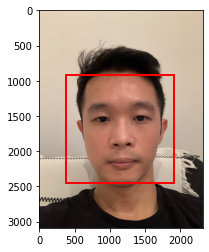

In [48]:
for dirname, _, filenames in os.walk('./app/front'):
    for filename in filenames:
        if filename.endswith('5.jpg'):
            predict(os.path.join(dirname, filename), frontal_detector)

### 6.1. Conclusion

The application shows the CNN model able to make correct predictions using real-life images. 

For future improvements, we can detect whether a person is wearing masks correctly and run our prediction in real-time on a video feed.